In [26]:
# Importing all needed packages
# Standard packages for data visualization
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt   
%matplotlib notebook

# Packages for reading astronomical data stored in fits files and accessing file paths
from astropy.io import fits  # to read fits files with python
import glob  # to find pathnames

# Packages for importing ad-hoc modules and other
import importlib
import sys
#importlib.reload(sys.modules['data_reduction']) # uncomment when you edit the module data_reduction.py
from data_reduction import *
import datetime

# Data reduction of optical spectroscopy
# Task #2: find the Master Flat!

In [27]:
# List of filenames that have been bias-corrected
fnames = glob.glob('not2mattia/*_b.fits*', recursive=True)   
fnames

['not2mattia/ALAe130145_b.fits',
 'not2mattia/ALAe130148_b.fits',
 'not2mattia/ALAe130147_b.fits',
 'not2mattia/ALAe130155_b.fits',
 'not2mattia/ALAe130144_b.fits',
 'not2mattia/ALAe130146_b.fits',
 'not2mattia/ALAe130149_b.fits',
 'not2mattia/ALAe130132_b.fits']

# Flat checks: lamp, high counts and history

In [28]:
# Doing the necessary checks on the flat frames and printing them out

COUNTS_THRESHOLD = 100000
FLAT_PX_PERC_MIN = 90

# List of filenames of the flat frames
flat_names = []
flat_frames = []
flat_masks = []
for file in fnames:
    hdul = fits.open(file)  # reading the fits file (headers and pixel values)
    
    # An HDU (Header Data Unit) is the highest level component of the FITS file structure, 
    # consisting of a header and (typically) a data array or table.
    
    if hdul[0].header['IMAGETYP'] == 'FLAT,LAMP':
        flat_names.append(file)  # add to the list of flat names
        lamp_type = hdul[0].header['OBJECT']  # to check if Halogen lamp is on
        xdim = hdul[1].header['NAXIS1']  # lenght of x axis
        ydim = hdul[1].header['NAXIS2']  # lenght of y axis
        n_pixels = xdim * ydim  # number of pixels
        
        flat_frames.append(hdul[1].data)  #add to the list of flat frames
        
        # Choose region of interest, where you compute statistics and fit the normalization function
        xmin, xmax, ymin, ymax = 500, 1750, 0, 1000 
        
        # Computing statistics of the pixel values within a window exluding 10% on each side of both axis
        stats = ImageStats("flat_frame_statistics") # define the object where saving the statistics, name is optional
        stats.compute_imstats(hdul[1].data, xmin, xmax, ymin, ymax)
        flat_mean = stats.mean
        flat_median = stats.median
        flat_std = stats.std
        
        # Counting percentage of pixels with lower values than COUNTS_THRESHOLD in the area of interest
        flat_mask_high = stats.counts_of_interest(hdul[1].data, xmin, xmax, ymin, ymax, COUNTS_THRESHOLD)
        flat_masks.append(flat_mask_high)
        flat_pixel_percentage = stats.px_perc
        
        # Checking that the master bias has been subtracted
        bias_check = hdul[0].header['HISTORY'] # will be printed below, check for each frame! 
        
        print(file, " lamp =", lamp_type, " frame =", xdim, "x", ydim, "nPixels =", n_pixels)
        print("Coordinates of the reigon of interest (xmin, xmax, ymin, ymax) =", xmin, xmax, ymin, ymax)
        print("Image statistics: mean =", flat_mean, " median =", flat_median, " std =", flat_std)
        print("In the region of interest",  "{:.2f}".format(flat_pixel_percentage), 
              "% of the pixels have a value higher than", COUNTS_THRESHOLD)
        print("HISTORY: ", bias_check)
        
        if flat_pixel_percentage < FLAT_PX_PERC_MIN: 
            print("\nWARNING: the percentage of pixles with a value lower than", COUNTS_THRESHOLD, 
                  "is lower than ", FLAT_PX_PERC_MIN, "%\n"
                  "Please choose a more representative area of interest.")
            
        print("")
    hdul.close()

flat_array = np.array(flat_frames)
flat_masks_array = np.array(flat_masks)

not2mattia/ALAe130148_b.fits  lamp = Halogen 2 Flat AT2017dtj  frame = 2148 x 2102 nPixels = 4515096
Coordinates of the reigon of interest (xmin, xmax, ymin, ymax) = 500 1750 0 1000
Image statistics: mean = 158305.59763468118  median = 158305.59763468118  std = 44232.556140646695
In the region of interest 90.05 % of the pixels have a value higher than 100000
HISTORY:  Master Bias subtracted on 2020-11-17 14:22:37 using master bias file...

not2mattia/ALAe130147_b.fits  lamp = Halogen 1 Flat AT2017dtj  frame = 2148 x 2102 nPixels = 4515096
Coordinates of the reigon of interest (xmin, xmax, ymin, ymax) = 500 1750 0 1000
Image statistics: mean = 159677.26197468117  median = 159677.26197468117  std = 44504.61700791956
In the region of interest 90.41 % of the pixels have a value higher than 100000
HISTORY:  Master Bias subtracted on 2020-11-17 14:22:37 using master bias file...

not2mattia/ALAe130149_b.fits  lamp = Halogen 3 Flat AT2017dtj  frame = 2148 x 2102 nPixels = 4515096
Coordinates 

<IPython.core.display.Javascript object>


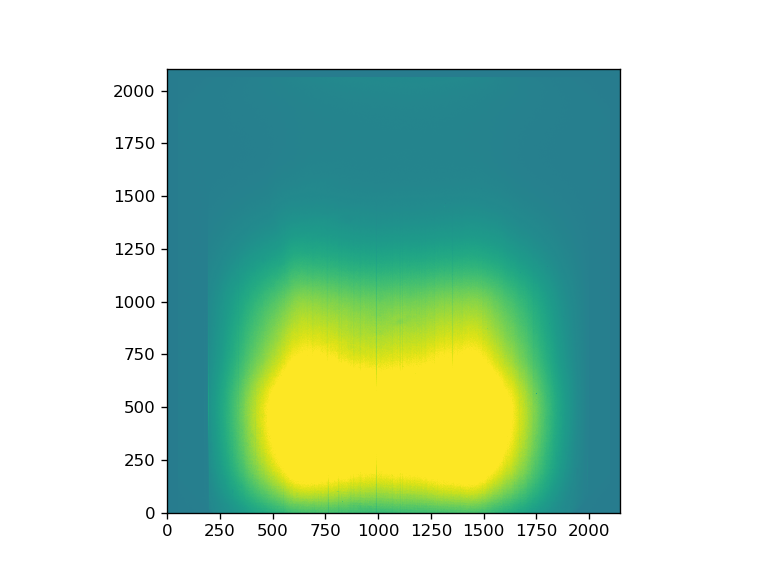

<IPython.core.display.Javascript object>


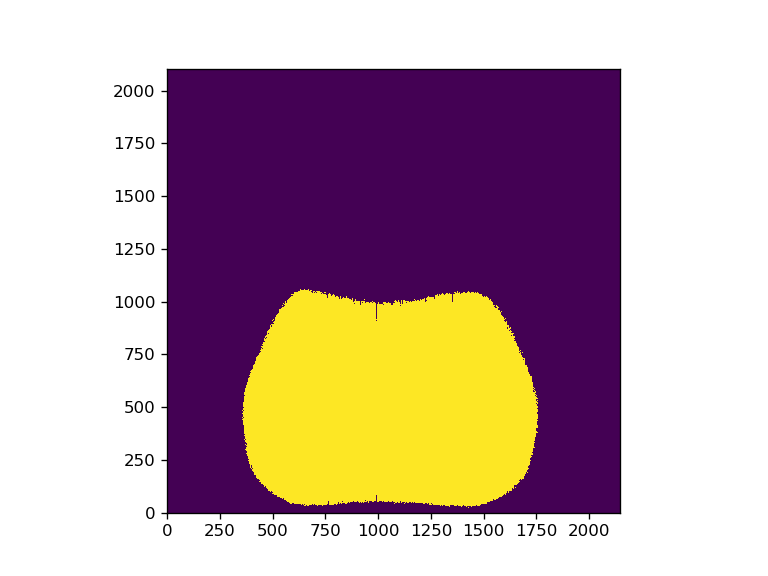

In [29]:
# Plotting one flat frame as an example and one mask for high counts
b = flat_array[0]
plt.figure()
plt.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))
plt.figure()
c = flat_masks_array[0]
c.reshape(b.shape)
plt.imshow(c, origin='lower')

# Fitting a 2D Polynomial ...work in progress...

<IPython.core.display.Javascript object>


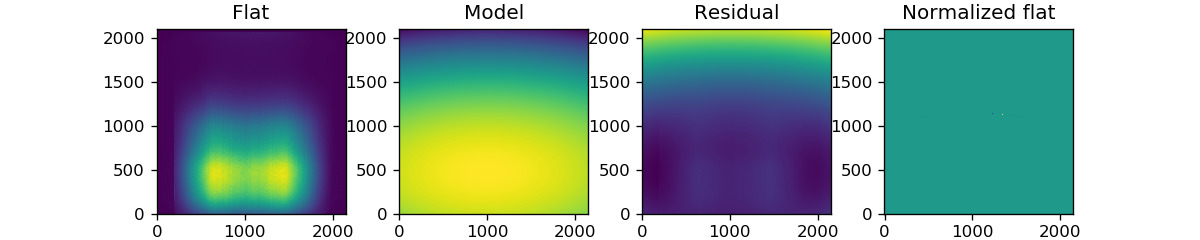

Text(0.5, 1.0, 'Normalized flat')

In [30]:
# Fitting each flat frame with a 2d polynomial
from scipy import interpolate

flat = flat_array[0]

xmin, xmax, ymin, ymax = 500, 1750, 0, 1000 

x, y = np.mgrid[xmin:xmax,ymin:ymax] # define grid for the region of interest

z = np.transpose(flat[ymin:ymax,xmin:xmax]) # frame data: y-axis is the first and x-axis is the second  

import warnings
from astropy.modeling import models, fitting

p_init = models.Polynomial2D(degree=3)
p_init.prepare_inputs(x, y)
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z) # fitting the region of interest

x_frame, y_frame = np.mgrid[0:xdim, 0:ydim] # define grid for the whole frame
poly = np.transpose(p(x_frame, y_frame)) # go back to axis order of original matrix 
resid = flat - poly
norm = flat / poly

# Plot the data with the best-fit model
plt.figure(figsize=(10, 2))
plt.subplot(1, 4, 1)
plt.imshow(flat, origin='lower')#, vmin=np.median(flat)-2*np.std(flat), vmax =np.median(flat)+2*np.std(flat))
plt.title("Flat")
plt.subplot(1, 4, 2)
plt.imshow(poly, origin='lower')#, vmin=np.median(poly)-2*np.std(poly), vmax =np.median(poly)+2*np.std(poly))
plt.title("Model")
plt.subplot(1, 4, 3)
plt.imshow(resid, origin='lower')#, vmin=np.median(resid)-2*np.std(resid), vmax =np.median(resid)+2*np.std(resid))
plt.title("Residual")
plt.subplot(1, 4, 4)
plt.imshow(norm, origin='lower')#, vmin=np.median(norm)-2*np.std(norm), vmax =np.median(norm)+2*np.std(norm))
plt.title("Normalized flat")

# Combining the normalized flat frames into the Master Flat ...bias->flat

<IPython.core.display.Javascript object>


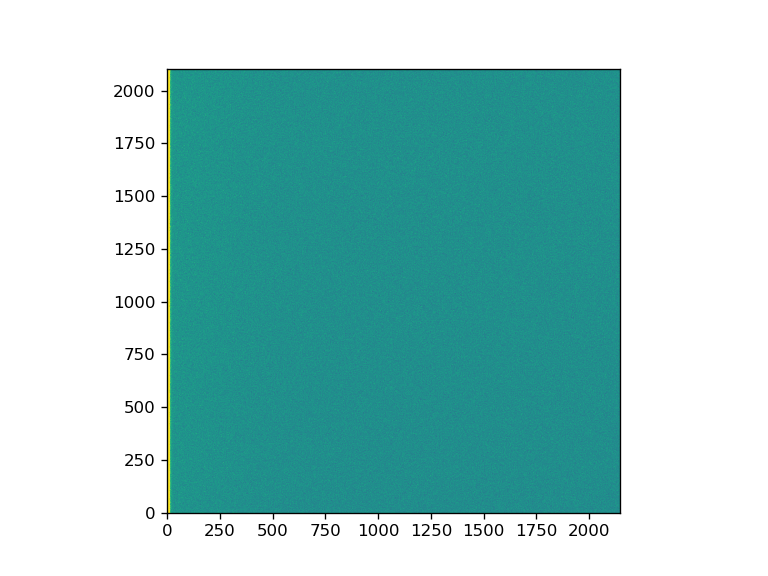

<IPython.core.display.Javascript object>


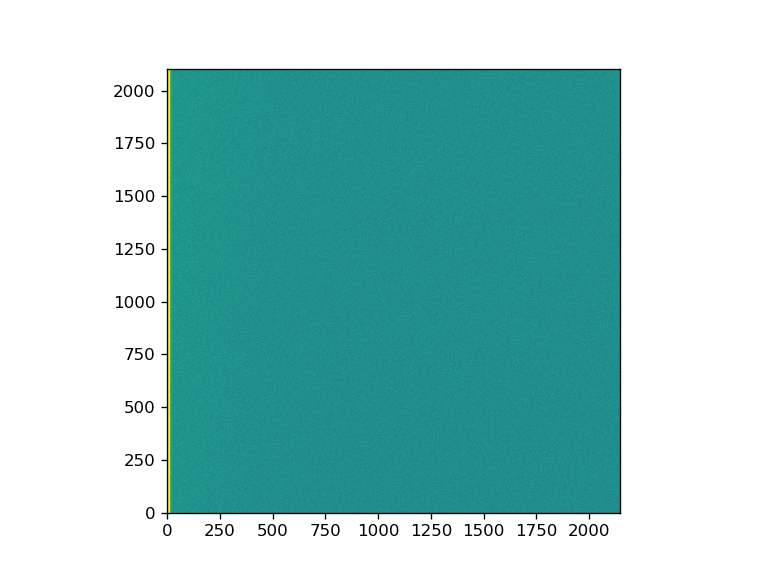

In [36]:
# Computing the master flat using a function defined in data_reduction.py module
# Two methods of combination are available: (1) average or (2) median

# need norm_flat_array

master_flat1 = get_master_flat(norm_flat_array, method="average", n_clip=2)
master_flat2 = get_master_flat(norm_flat_array, method="median", n_clip=2)

b = master_flat1
plt.figure()
plt.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

c = master_flat2
plt.figure()
plt.imshow(c, origin='lower', vmin=np.median(c)-2*np.std(c), vmax =np.median(c)+2*np.std(c))

# Creating a fits file for the master flat obtained with the average
hdu = fits.ImageHDU(master_flat1)

hdr = fits.Header()
now = datetime.datetime.now()
now_string = now.strftime("%Y-%m-%d %H:%M:%S")
hdr['COMMENT'] = "Master flat frame (average of flat frames) obtained on " + now_string
empty_primary = fits.PrimaryHDU(header=hdr)

hdul = fits.HDUList([empty_primary, hdu])
hdul.writeto('not2mattia/master_flat_average.fits', overwrite=True)

# Dividing the Master Flat from the object frames ...bias -> flat

In [178]:
# Subtracting the master flat (mean) from all other frames that are not flat frames

for file in fnames:
    hdul = fits.open(file)
    
    if hdul[0].header['IMAGETYP'] != 'flat':
        hdul[1].data = hdul[1].data / masterflat1
        print("Master flat divided ... frame", file, "of image type:", hdul[0].header['IMAGETYP'])
        
        comment = "Master flat subtracted on: "
        now = datetime.datetime.now()
        comment += now.strftime("%Y-%m-%d %H:%M:%S")
        hdul[0].header['HISTORY'] = comment
        hdul[0].header['COMMENT'] = comment
        
        new_file_name = file.replace(".fits", "_f.fits")
        hdul.writeto(new_file_name)
        print("New fits file created for the flat-subtracted frame:", new_file_name, "\n")
    
    hdul.close()

Master Bias subtracted from frame not2mattia/ALAe130147.fits of image type: FLAT,LAMP
New fits file created for the bias-subtracted frame: not2mattia/ALAe130147_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130149.fits of image type: FLAT,LAMP
New fits file created for the bias-subtracted frame: not2mattia/ALAe130149_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130132.fits of image type: OBJECT
New fits file created for the bias-subtracted frame: not2mattia/ALAe130132_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130155.fits of image type: OBJECT
New fits file created for the bias-subtracted frame: not2mattia/ALAe130155_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130145.fits of image type: OBJECT
New fits file created for the bias-subtracted frame: not2mattia/ALAe130145_b.fits 

Master Bias subtracted from frame not2mattia/ALAe130146.fits of image type: WAVE,LAMP
New fits file created for the bias-subtracted frame: not2mattia/ALAe13014

# Playing with regions

<IPython.core.display.Javascript object>


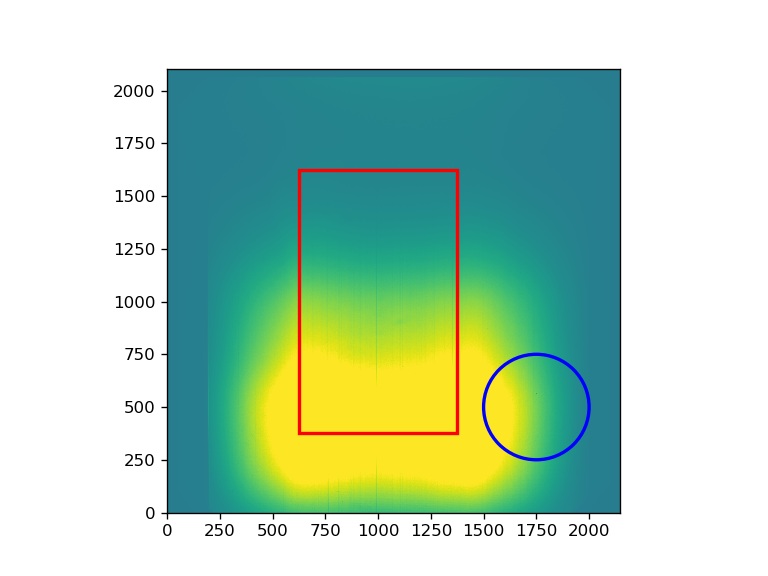

<IPython.core.display.Javascript object>


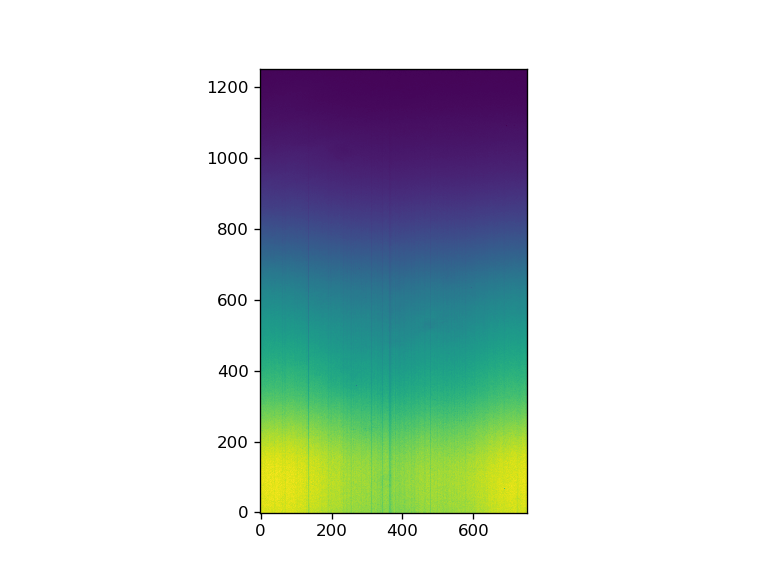

<IPython.core.display.Javascript object>


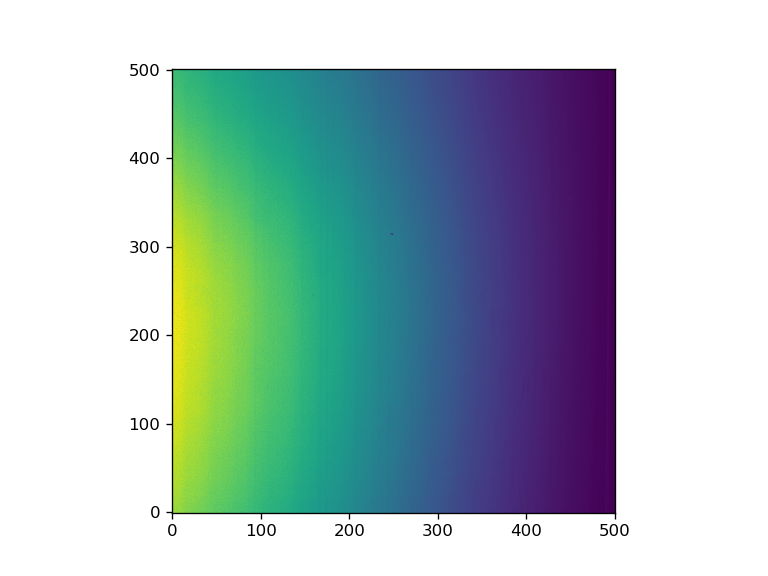

In [165]:
# Selecting a regions: create one and mask it!

from regions import *
from astropy.coordinates import Angle

fig, ax = plt.subplots(1, 1)
ax.imshow(b, origin='lower', vmin=np.median(b)-2*np.std(b), vmax =np.median(b)+2*np.std(b))

center = PixCoord(x=1000, y=1000)
width = 750
height = 1250
angle = Angle(0, 'deg')
reg = RectanglePixelRegion(center=center, width=width,
                           height=height, angle=angle)

patch = reg.as_artist(facecolor='none', edgecolor='red', lw=2)
ax.add_patch(patch)

center2 = PixCoord(x=1750, y=500)
radius = 250
reg2 = CirclePixelRegion(center=center2, radius=radius)
patch2 = reg2.as_artist(facecolor='none', edgecolor='blue', lw=2)
ax.add_patch(patch2)

mask = reg.to_mask()
interest = mask.cutout(b)
plt.figure()
plt.imshow(interest, origin='lower')

mask2 = reg2.to_mask()
interest2 = mask2.cutout(b)
plt.figure()
plt.imshow(interest2, origin='lower')